In [ ]:
!pip install datasets

     |████████████████████████████████| 270 kB 13.3 MB/s 
     |████████████████████████████████| 243 kB 43.0 MB/s 
     |████████████████████████████████| 1.3 MB 38.7 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 123 kB 24.3 MB/s 
     |████████████████████████████████| 294 kB 2.4 MB/s 
     |████████████████████████████████| 142 kB 47.7 MB/s 


In [ ]:
usePretrained = True
DriveAccess = False 

In [ ]:
if DriveAccess:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

## Data Preprocessing

In [ ]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # removing contractions
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "what is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
def format_dataset(dataset):

  text = []
  for dialog in dataset:
    for index in range(1,len(dialog)):
      sentence1 = dialog[index-1]
      sentence2 = dialog[index]
      sentence1 = sentence1.rstrip()
      sentence2 = sentence2.rstrip()

      sentence1 = preprocess_sentence(sentence1)
      sentence2 = preprocess_sentence(sentence2)
      text.append(sentence1)
      text.append("[start] " + sentence2 + " [end]")
  
  return text

In [ ]:
from datasets import load_dataset
dataset = load_dataset('daily_dialog')

Using custom data configuration default
Reusing dataset daily_dialog (/root/.cache/huggingface/datasets/daily_dialog/default/1.0.0/c03444008e9508b8b76f1f6793742d37d5e5f83364f8d573c2747bff435ea55c)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_text = format_dataset(dataset['train']['dialog'])
test_text = format_dataset(dataset['test']['dialog'])
valid_text = format_dataset(dataset['validation']['dialog'])

In [ ]:
print(f"Train Length: {len(train_text)}")
print(f"Test Length: {len(test_text)}")
print(f"Valid Length: {len(valid_text)}")

Train Length: 152104
Test Length: 13480
Valid Length: 14138


In [ ]:
dataset = train_text + test_text + valid_text

In [ ]:
index = len(train_text)
train_input = [train_text[i] for i in range(0,index) if i % 2 == 0]
train_output = [train_text[i] for i in range(0,index) if i % 2 == 1]
train_pairs = [(train, test) for train, test in zip(train_input, train_output)]

In [ ]:
index = len(test_text)
test_input = [test_text[i] for i in range(0,index) if i % 2 == 0]
test_output = [test_text[i] for i in range(0,index) if i % 2 == 1]
test_pairs = [(train, test) for train, test in zip(test_input, test_output)]

In [ ]:
index = len(valid_text)
val_input = [valid_text[i] for i in range(0,index) if i % 2 == 0]
val_output = [valid_text[i] for i in range(0,index) if i % 2 == 1]
val_pairs = [(train, test) for train, test in zip(val_input, val_output)]

## Vectorizing the text data

In [ ]:
vocab_size = 15000
sequence_length = 40
batch_size = 64

strip_chars_one = string.punctuation
strip_chars_one = strip_chars_one.replace("?", "")
strip_chars_one = strip_chars_one.replace("!", "")
strip_chars_one = strip_chars_one.replace(".", "")
strip_chars_one = strip_chars_one.replace(",", "")

def custom_standardization_encoder(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars_one), "")


inp_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
    standardize = custom_standardization_encoder
)

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace("?", "")
strip_chars = strip_chars.replace("!", "")
strip_chars = strip_chars.replace(".", "")
strip_chars = strip_chars.replace(",", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

out_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length+1,
    standardize=custom_standardization,
)

index = len(dataset)
inp_texts = [dataset[i] for i in range(0,index) if i % 2 == 0]
out_texts = [dataset[i] for i in range(0,index) if i % 2 == 1]


inp_vectorization.adapt(inp_texts)
out_vectorization.adapt(out_texts)


In [ ]:
def format_dataset(inp, out):
    inp = inp_vectorization(inp)
    out = out_vectorization(out)
    return ({"encoder_inputs": inp, "decoder_inputs": out[:, :-1],}, out[:, 1:])


def make_dataset(pairs):
    inp_texts, out_texts = zip(*pairs)
    inp_texts = list(inp_texts)
    out_texts = list(out_texts)
    dataset = tf.data.Dataset.from_tensor_slices((inp_texts, out_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 40)
inputs["decoder_inputs"].shape: (64, 40)
targets.shape: (64, 40)


In [ ]:
import numpy as np
embedding_matrix_inp = np.random.uniform(-1, 1, (vocab_size, 100))
embedding_matrix_out = np.random.uniform(-1, 1, (vocab_size, 100))
# embedding_matrix = np.zeros((vocab_size, 100))

In [ ]:
from gensim.models import Word2Vec
model_i = Word2Vec(sentences=[sentence[0].split() for sentence in train_pairs], size=100, min_count=1, window=3, workers=4, sg=1)
model_o = Word2Vec(sentences=[sentence[1].split() for sentence in train_pairs], size=100, min_count=1, window=3, workers=4, sg=1)

In [ ]:
from tqdm import tqdm_notebook
for idx, word in tqdm_notebook(enumerate(inp_vectorization.get_vocabulary())):
  if word in model_i.wv.vocab:
    embedding_matrix_inp[idx] = model_i.wv[word]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

In [ ]:
for idx, word in tqdm_notebook(enumerate(out_vectorization.get_vocabulary())):
  if word in model_o.wv.vocab:
    embedding_matrix_out[idx] = model_o.wv[word]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


0it [00:00, ?it/s]

# Question 1

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
      config = {
                'num_heads': self.num_heads,
            'embed_dim': self.embed_dim,
            'dense_dim':self.dense_dim,
               }
      base_config = super(TransformerEncoder, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, weights, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, trainable=True, weights=[weights], mask_zero=True
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
      config = {
                'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
            'sequence_length':self.sequence_length,
            'weights': self.weights}
      base_config = super(PositionalEmbedding, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )

        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
      config = {
                'num_heads': self.num_heads,
            'embed_dim': self.embed_dim,
            'latent_dim':self.latent_dim,
                }
      base_config = super(TransformerDecoder, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

In [ ]:
embed_dim = 100
latent_dim = 2048
num_heads = 8

# Encoder 
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim, embedding_matrix_inp)(encoder_inputs)
encoder1 = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder2 = TransformerEncoder(embed_dim, latent_dim, num_heads)(encoder1)
encoder = keras.Model(encoder_inputs, encoder2)

# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim, embedding_matrix_out)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder.output])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
epochs = 30

transformer.summary()
transformer.compile(
    "nadam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding_2 (Positio (None, None, 100)    1504000     encoder_inputs[0][0]             
__________________________________________________________________________________________________
transformer_encoder_2 (Transfor (None, None, 100)    734648      positional_embedding_2[0][0]     
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = '/content/drive/MyDrive/HW-06/model-transformer.h5'

cp_callback = [ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor = 'val_loss',mode = 'min',save_best_only=True),
               EarlyStopping(patience=10),]
               

In [ ]:
if not usePretrained:
  import time 
  start = time.time()
  history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, shuffle=True, callbacks=[cp_callback])
  end = time.time()
  print(f"Transformer Training Time: {end - start}")

Epoch 1/30
1189/1189 [==============================] - 230s 183ms/step - loss: 1.7173 - accuracy: 0.2998 - val_loss: 1.4674 - val_accuracy: 0.3482
Epoch 2/30
1189/1189 [==============================] - 216s 181ms/step - loss: 1.4928 - accuracy: 0.3470 - val_loss: 1.3909 - val_accuracy: 0.3668
Epoch 3/30
1189/1189 [==============================] - 215s 181ms/step - loss: 1.4208 - accuracy: 0.3640 - val_loss: 1.3528 - val_accuracy: 0.3760
Epoch 4/30
1189/1189 [==============================] - 216s 181ms/step - loss: 1.3681 - accuracy: 0.3773 - val_loss: 1.3346 - val_accuracy: 0.3800
Epoch 5/30
1189/1189 [==============================] - 216s 181ms/step - loss: 1.3250 - accuracy: 0.3889 - val_loss: 1.3241 - val_accuracy: 0.3847
Epoch 6/30
1189/1189 [==============================] - 216s 182ms/step - loss: 1.2888 - accuracy: 0.3989 - val_loss: 1.3187 - val_accuracy: 0.3876
Epoch 7/30
1189/1189 [==============================] - 216s 182ms/step - loss: 1.2585 - accuracy: 0.4076 - val_

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

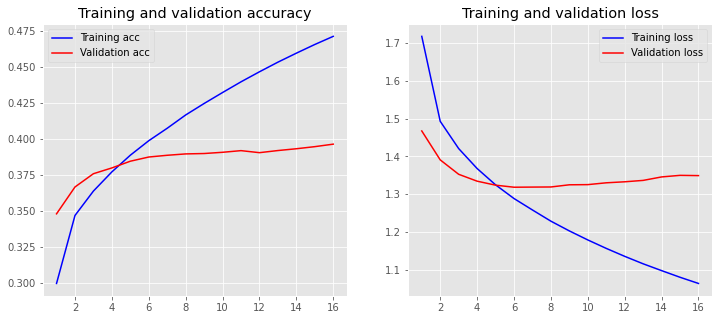

In [ ]:
  plot_history(history)

## Decoding test sentences

Finally, let's demonstrate how to reply to a conversation.
We simply feed into the model the vectorized input sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [ ]:
out_vocab = out_vectorization.get_vocabulary()
out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = inp_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = out_vectorization([decoded_sentence])[:, :-1]
        predictions = model_transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
          break
    return decoded_sentence

In [ ]:
input_sentence = ['what do you do for your weekend?']
turn_count = 10 

In [ ]:
for idx in range(turn_count):
  print(f'*************** Turn {idx + 1} ***************\n') 
  print(input_sentence)
  translated = decode_sequence(input_sentence)
  print(translated)
  input_sentence = translated.strip("[start]").strip("[end]")
  print()
  print('***************'*3) 

*************** Turn 1 ***************

['what do you do for your weekend?']
[start] i am a little bit tired . [end]

*********************************************
*************** Turn 2 ***************

 i am a little bit tired . 
[start] what do you mean ? [end]

*********************************************
*************** Turn 3 ***************

 what do you mean ? 
[start] i am not sure . i am a little tired . [end]

*********************************************
*************** Turn 4 ***************

 i am not sure . i am a little tired . 
[start] i am going to have to get a lot of money . [end]

*********************************************
*************** Turn 5 ***************

 i am going to have to get a lot of money . 
[start] i am going to have to get a lot of money . [end]

*********************************************
*************** Turn 6 ***************

 i am going to have to get a lot of money . 
[start] i am going to have to get a lot of money . [end]

************

In [ ]:
sentences = [
             'where have you been?',
             'what is your name?',
             'where are you from?',
             'what do you want to drink?'
             ]

In [ ]:
for input_sentence in sentences:
    translated = decode_sequence(input_sentence)
    print(input_sentence)
    print(translated)
    print('\n***************\n')

where have you been?
[start] i am going to go to the beach . [end]

***************

what is your name?
[start] i am a little bit tired . [end]

***************

where are you from?
[start] i am going to the park . [end]

***************

what do you want to drink?
[start] i am going to have a new one . [end]

***************



In [ ]:
for _ in range(30):
    input_sentence = random.choice(test_input)
    translated = decode_sequence(input_sentence)
    print(input_sentence)
    print(translated)
    print('***************')

a you must be wily . it is nice to meet you .
[start] hello , mr . smith . [end]
***************
and what is the cause of that ?
[start] it is a little bit of a problem . [end]
***************
ok , got it . is there anything else i need to know before we go ahead ?
[start] i am afraid you have to pay a discount . [end]
***************
that is kind of weird ! what if she is a psycho or something like that ?
[start] he is a little bit tired . [end]
***************
good afternoon . british airline . is there any thing i can do for you ?
[start] yes , i am looking for a new one . [end]
***************
so , if the cause is poverty , there should be a program to make the country richer . if the problem is resources , share them .
[start] that is right . the government is a good thing to do is not really good . [end]
***************
here are some . they re on special sale these days .
[start] i am afraid i have not seen you for a long time . [end]
***************
i like seafood on my pizza .


# Question 2

In [ ]:
out_vocab = out_vectorization.get_vocabulary()
out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = inp_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = out_vectorization([decoded_sentence])[:, :-1]
        predictions = model_transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
          break
    return decoded_sentence





In [ ]:
input_sentence = ['what do you do for your weekend?']
turn_count = 10 

In [ ]:
for idx in range(turn_count):
  print(f'*************** Turn {idx + 1} ***************\n') 
  print(input_sentence)
  translated = decode_sequence(input_sentence)
  print(translated)
  input_sentence = translated.strip("[start]").strip("[end]")
  print()
  print('***************'*3) 

*************** Turn 1 ***************

['what do you do for your weekend?']
[start] i am a little bit tired . [end]

*********************************************
*************** Turn 2 ***************

 i am a little bit tired . 
[start] what do you mean ? [end]

*********************************************
*************** Turn 3 ***************

 what do you mean ? 
[start] i am not sure . i am a little tired . [end]

*********************************************
*************** Turn 4 ***************

 i am not sure . i am a little tired . 
[start] i am going to have to get a lot of money . [end]

*********************************************
*************** Turn 5 ***************

 i am going to have to get a lot of money . 
[start] i am going to have to get a lot of money . [end]

*********************************************
*************** Turn 6 ***************

 i am going to have to get a lot of money . 
[start] i am going to have to get a lot of money . [end]

************

# Question 3

In [ ]:
from keras.layers import Embedding
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model

In [ ]:
sequence_length = 40
def seq2seq_model_builder(HIDDEN_DIM=300):    
  # Encoder 
  encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
  x = Embedding(input_dim=vocab_size, output_dim=100, input_length=sequence_length, trainable=True, weights=[embedding_matrix_inp])(encoder_inputs)
  encoder1, state_h, state_c = LSTM(HIDDEN_DIM, return_state=True)(x)

  # Decoder
  decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")

  x = Embedding(input_dim=vocab_size, output_dim=100, input_length=sequence_length, trainable=True, weights=[embedding_matrix_out])(decoder_inputs)
  x, _, _ = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)(x, initial_state=[state_h, state_c])

  decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

  model = keras.Model(
      [encoder_inputs, decoder_inputs], decoder_outputs
  )
  return model
  


In [ ]:
model = seq2seq_model_builder(HIDDEN_DIM=300)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1500000     encoder_inputs[0][0]             
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    1500000     decoder_inputs[0][0]             
______________________________________________________________________________________________

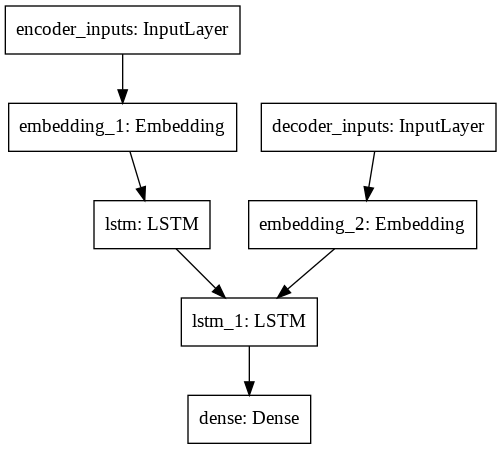

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./seq2seq.png')

In [ ]:
model.compile(optimizer='adam', loss ='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs = 30

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = '/content/drive/MyDrive/HW-06/model-lstm.ckpt'

cp_callback = [ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_loss',mode = 'min',save_best_only=True),
               EarlyStopping(patience=5),]

In [ ]:
history = history_lstm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

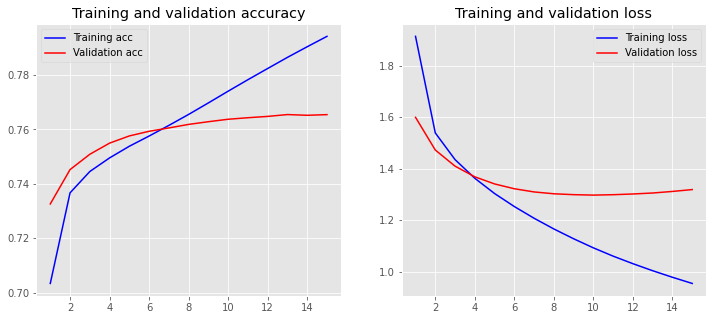

In [ ]:
plot_history(history)

In [ ]:
out_vocab = out_vectorization.get_vocabulary()
out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = inp_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = out_vectorization([decoded_sentence])[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
          break
    return decoded_sentence

In [ ]:
input_sentence = ['what do you do for your weekend?']
turn_count = 10 

In [ ]:
for idx in range(turn_count):
  print(f'*************** Turn {idx + 1} ***************\n') 
  print(input_sentence)
  translated = decode_sequence(input_sentence)
  print(translated)
  input_sentence = translated.strip("[start]").strip("[end]")
  print()
  print('***************'*3) 

*************** Turn 1 ***************

['what do you do for your weekend?']
[start] i am not sure . [end]

*********************************************
*************** Turn 2 ***************

 i am not sure . 
[start] i am sorry to hear that . [end]

*********************************************
*************** Turn 3 ***************

 i am sorry to hear that . 
[start] i am sorry to hear that . [end]

*********************************************
*************** Turn 4 ***************

 i am sorry to hear that . 
[start] i am sorry to hear that . [end]

*********************************************
*************** Turn 5 ***************

 i am sorry to hear that . 
[start] i am sorry to hear that . [end]

*********************************************
*************** Turn 6 ***************

 i am sorry to hear that . 
[start] i am sorry to hear that . [end]

*********************************************
*************** Turn 7 ***************

 i am sorry to hear that . 
[start] i am 

In [ ]:
for _ in range(30):
    input_sentence = random.choice(test_input)
    translated = decode_sequence(input_sentence)
    print(input_sentence)
    print(translated)
    print('***************')

i did not like it at all until i started to learn violin when i was eight . from then on . classical music has been an important part of my life .
[start] i know . i have been working in the city centre . [end]
***************
i should not be surprised , many customers have the same opinion . do you have any suggestion in mind ? our salesman told your secretary that the price could be negotiable .
[start] i see . i will take it . [end]
***************
no , i m sorry . i disagree . i don t think you ve been working at full speed at all .
[start] i know . i have been working with a lot of things . [end]
***************
i have heard its name is connected with someone , is that right ?
[start] i am afraid not . i am afraid i cannot . [end]
***************
there is plenty of room for our king sized bed , and i love the light in this room .
[start] ok . i will take it . [end]
***************
this is room . where is my laundry ? you promised to send to me this morning .
[start] i am sorry , s

# Question 4

In [ ]:
sentences = [
             'where have you been?',
             'what is your name?',
             'where are you from?',
             'what do you want to drink?'
             ]

In [ ]:
for input_sentence in sentences:
    translated = decode_sequence(input_sentence)
    print(input_sentence)
    print(translated)
    print('\n***************\n')

where have you been?
[start] i am a little bit of a dancer . [end]

***************

what is your name?
[start] i am not sure . [end]

***************

where are you from?
[start] i am in the mood for a few days . [end]

***************

what do you want to drink?
[start] i am going to have a new projector . [end]

***************

